In [1]:
#!/usr/bin/env python

Demo: trinidi.resolution Module
==================================

This script illustrates the functionality of the `trinidi.resolution` submodule.

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from trinidi import cross_section, resolution, util

Overview
--------

The resolution operator, $R$, models the uncertainty distribution
of the emission time of the neutrons. In the idealized case, when the
neutron pulse is instantaneous, the time-of-arrival (TOA) is equal to
the time-of-flight (TOF) and the resolution operator is equal to the
identity: $R = I$. However, in practice the neutron pulse often
has a significant durantion and match the TOA (i.e. the measured time
at the detector plane) does not deterministically the TOF (i.e. the
neutron energy).

If $Z$ is the array of areal densities and $D$ is the cross section
dictionary, then the expected transmission $Q$ is

  $$Q = \exp (-ZD) R = Q_0 R\;.$$

In this script we will generate artificial raw transmission data, $Q_0$,
and the resolution operator $R$ to generate the blurred transmission
spectrum $Q = Q_0 R$. We define the blurred transmission spectrum to
correspond to the TOA sampling vector $t_A$ and the raw transmission to
correspond the the TOF sampling vector, $t_F$. The $t_A$ samples are a
subset of the $t_F$ samples so that boundary effects due to the blurring
are avoided.

Defining the TOA sampling vector
--------------------------------
By our convention, the $t_A$ vector has equidistant and increasing
sampling.

In [3]:
Δt = 0.30  # bin size in μs
t_A = np.arange(72, 450, Δt)
N_A = t_A.size  # number of TOA bins

The corresponding energy range of the neutrons is computed and displayed
below. Note that the corresponding energy samples are neither
equidistant nor increasing.

In [4]:
flight_path_length = 10  # flight path length in m

E = util.time2energy(t_A, flight_path_length)

print(f"t_A = [{t_A[0]:.3f}, {t_A[1]:.3f}, ..., {t_A[-1]:.3f}] μs")
print(f"E = [{E[-1]:.3f}, {E[-2]:.3f}, ..., {E[0]:.3f}] eV")

t_A = [72.000, 72.300, ..., 449.700] μs
E = [2.585, 2.588, ..., 100.830] eV


Defining the Output Shape
---------------------------
When defining the resolution operator, the `output_shape` of the
operator must be passed to the constructor. The `output_shape` is equal
to `projection_shape + (N_A,)` where `projection_shape` is usually the
size of the detector.

In [5]:
projection_shape = (3, 3)
output_shape = projection_shape + (N_A,)

Defining a Resolution Operator
------------------------------
In this example we use a set of primitive rectangular convolution
kernels. The `t_F` TOF sampling vector is retrieved from `R` and in
general it is larger than `t_A`.

In [6]:
kernels = [np.ones(10) / 10, np.ones(20) / 20, np.ones(30) / 30]
R = resolution.ResolutionOperator(output_shape, t_A, kernels=kernels)
t_F = R.t_F  # the TOF sampling vector
N_F = t_F.size

print(f"t_A = [{t_A[0]:.3f}, {t_A[1]:.3f}, ..., {t_A[-1]:.3f}] μs")
print(f"t_F = [{t_F[0]:.3f}, {t_F[1]:.3f}, ..., {t_F[-1]:.3f}] μs")

print(f"{N_F = } ≥ {N_A = }")

t_A = [72.000, 72.300, ..., 449.700] μs
t_F = [69.450, 69.750, ..., 454.050] μs
N_F = 1283 ≥ N_A = 1260


We can display the resolution operator attributes like this:

In [7]:
print(R)

<class 'trinidi.resolution.ResolutionOperator'>
    input_shape = (3, 3, 1283) = projection_shape + (N_F,)
    output_shape = (3, 3, 1260) = projection_shape + (N_A,)

    projection_shape = (3, 3)
    N_F = 1283
    N_A = 1260
        


Next, we can apply the resolution operator to a synthetic transmission
spectrum.

Below we define a cross section dictionary, `D`, using the `t_F`
sampling vector. The areal densities, `Z` are equal to `z.T` at every pixel.

In [8]:
isotopes = ["Pu-239", "U-235"]
N_M = len(isotopes)  # number of isotopes

z = np.array([[1e-3], [2e-3]])  # areal density in mol/cm²
Z = np.ones(projection_shape + (1,)) @ z.T  # 2D areal density map
print(f"{Z[0,0] = } [mol/cm²]")  # printing first pixel areal densities


D = cross_section.XSDict(isotopes, t_F, flight_path_length)  # cross section in cm²/mol

Z[0,0] = array([0.001, 0.002]) [mol/cm²]


The synthetic raw spectrum, `Q0`, and the blurred spectrum `Q` are
computed and plotted below. We also plot the associated weights that
indicate at which TOF which kernels are active.

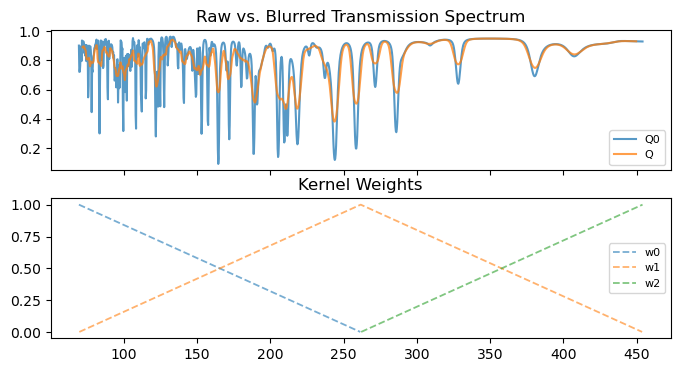

In [9]:
Q0 = np.exp(-Z @ D.values)
Q = R(Q0)

fig, ax = plt.subplots(2, 1, figsize=[8, 4], sharex=True)
ax = np.atleast_1d(ax)
ax[0].plot(t_F, Q0[0, 0], label="Q0", alpha=0.75)
ax[0].plot(t_A, Q[0, 0], label="Q", alpha=0.75)
ax[0].legend(prop={"size": 8})
ax[0].set_title("Raw vs. Blurred Transmission Spectrum")
R.plot_kernel_weights(ax[1])

plt.show()

Defining a General Resolution Operator
--------------------------------------
If we have a function that computes the blurring kernel as a function
of TOA, below we show how we can create the corresponding kernels. We
illustrate this using the built-in `lansce_fp5_kernel` function
and the `equispaced_kernels` function.

The `lansce_fp5_kernel` function computes the kernel shape as
a function of TOA and other parameters for a particular flight path
facility. Below we generate the kernel at the center TOA.

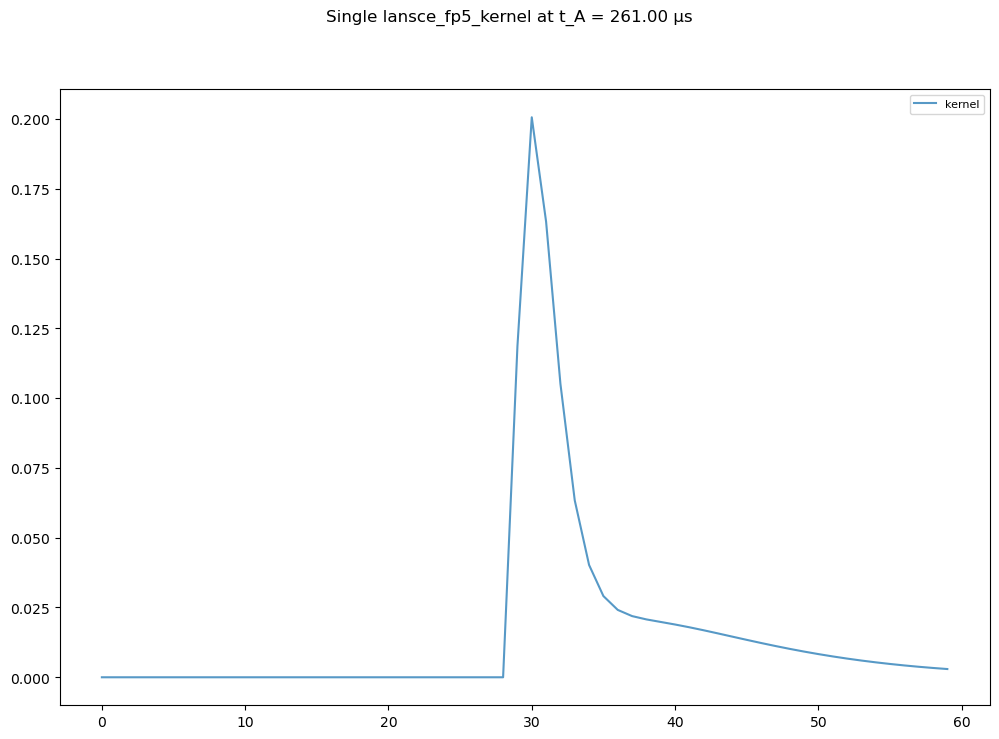

In [10]:
i = N_A // 2  # center index
kernel = resolution.lansce_fp5_kernel(t_A[i], Δt, flight_path_length)


fig, ax = plt.subplots(1, 1, figsize=[12, 8], sharex=True)
ax = np.atleast_1d(ax)
ax[0].plot(kernel, label="kernel", alpha=0.75)
ax[0].legend(prop={"size": 8})
fig.suptitle(f"Single lansce_fp5_kernel at t_A = {t_A[i]:.2f} μs")
# plt.savefig('')
plt.show()

For the resolution operator we require these kernels at equispaced TOAs.
First we need a function `g` with a single argument, `t_A`.

In [11]:
# i.e. g(t_A) == resolution.lansce_fp5_kernel(t_A, Δt, flight_path_length)
g = lambda t_A: resolution.lansce_fp5_kernel(t_A, Δt, flight_path_length)

The `equispaced_kernels` function generates the appropriate kernels.

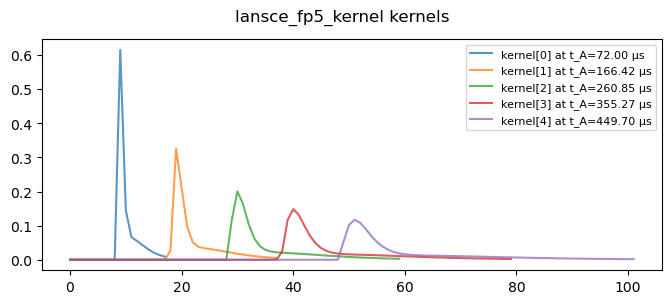

In [12]:
num_kernels = 5
kernels, t_As = resolution.equispaced_kernels(t_A, num_kernels, g)

fig, ax = plt.subplots(1, 1, figsize=[8, 3], sharex=True)
ax = np.atleast_1d(ax)
for i, kernel in enumerate(kernels):
    ax[0].plot(kernel, label=f"kernel[{i}] at t_A={t_As[i]:.2f} μs", alpha=0.75)
ax[0].legend(prop={"size": 8})
fig.suptitle(f"lansce_fp5_kernel kernels")
# plt.savefig('')
plt.show()

Below we show the resulting synthetic spectra.

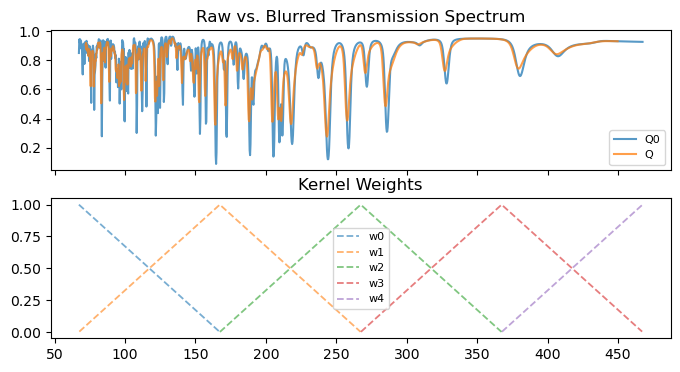

In [13]:
R = resolution.ResolutionOperator(output_shape, t_A, kernels=kernels)
t_F = R.t_F

D = cross_section.XSDict(isotopes, t_F, flight_path_length)  # cross section in cm²/mol


Q0 = np.exp(-Z @ D.values)
Q = R(Q0)

fig, ax = plt.subplots(2, 1, figsize=[8, 4], sharex=True)
ax = np.atleast_1d(ax)
ax[0].plot(t_F, Q0[0, 0], label="Q0", alpha=0.75)
ax[0].plot(t_A, Q[0, 0], label="Q", alpha=0.75)
ax[0].legend(prop={"size": 8})
ax[0].set_title("Raw vs. Blurred Transmission Spectrum")
R.plot_kernel_weights(ax[1])

plt.show()

Identity Resolution Operator
----------------------------
If it is desired to omit the resolution operator, you can simply create
an identity resolution operator setting the `kernels=None`
argument.

In [14]:
R = resolution.ResolutionOperator(output_shape, t_A, kernels=None)
t_F = R.t_F
N_F = t_F.size

Note: This is equivalent to using a single dirac kernel:

In [15]:
print(R.kernels)

[array([1])]


Only in the case of the identity operator the TOF and TOA sampling
vectors are equal to each other and have the same length, i.e. R is
a square linear operator.

In [16]:
if np.allclose(t_F, t_A) and (N_F == N_A):
    print("t_F == t_A")
    print(f"N_F == N_A == {N_A}")

t_F == t_A
N_F == N_A == 1260


Below we show the resulting synthetic spectra (which are of course equal).

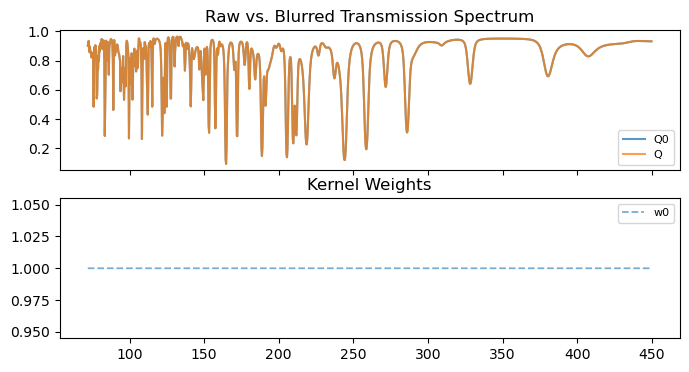

In [17]:
D = cross_section.XSDict(isotopes, t_F, flight_path_length)  # cross section in cm²/mol


Q0 = np.exp(-Z @ D.values)
Q = R(Q0)

fig, ax = plt.subplots(2, 1, figsize=[8, 4], sharex=True)
ax = np.atleast_1d(ax)
ax[0].plot(t_F, Q0[0, 0], label="Q0", alpha=0.75)
ax[0].plot(t_A, Q[0, 0], label="Q", alpha=0.75)
ax[0].legend(prop={"size": 8})
ax[0].set_title("Raw vs. Blurred Transmission Spectrum")
R.plot_kernel_weights(ax[1])

plt.show()